# Example - Real Electronics Data

In [62]:
import os
import sys
from datetime import datetime
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch

sys.path.append('../src')
import deepymod_torch.VE_params as VE_params
import deepymod_torch.VE_datagen as VE_datagen
from deepymod_torch.DeepMod import run_deepmod

# random seeding
np_seed = 4
torch_seed = 0
np.random.seed(np_seed)
torch.manual_seed(torch_seed)

In [63]:
general_path = 'Oscilloscope data CRI electronics analogy/'
specific_path = 'AWG 7V half sinc KELVIN cap 1000/' # It is precisely here that changes the data we are grabbing to test.
path = general_path + specific_path

# Some of these factors are just for saving at the end but...
# ... input_type is used in recalc after DM
# ... omega is used in time scaling.
# ... mech_model is used to predict coeffs and recover mech params
input_type = 'Strain'
mech_model = 'GKM'
func_desc = 'Half Sinc'
omega = 2*np.pi * 5 * 0.1
Amp = 7

channel_1_data = np.loadtxt(path+'Channel 1 total voltage.csv', delimiter=',', skiprows=3)
channel_2_data = np.loadtxt(path+'Channel 2 voltage shunt resistor.csv', delimiter=',', skiprows=3)

The data contains a 'dead' period at the beginning before the voltage manipulation began, and then restarts the manipulation later on. We do not need to keep this data as it provides very little new information and makes the data significantly harder to fit. Below, by plotting the voltage data and tweaking the start and end points, we can isolate the interesting data.

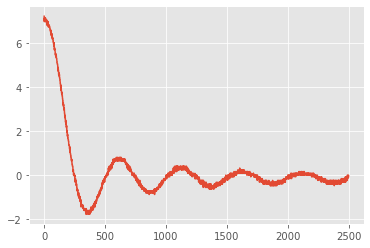

In [65]:
# plt.plot(channel_1_data[:, 1])
plt.plot(channel_1_data[806:-759, 1])

In [4]:
lower = 806
upper = -759

voltage_array = channel_1_data[lower:upper, 1:]
voltage_shunt_array = channel_2_data[lower:upper, 1:]
time_array = channel_1_data[lower:upper, :1]

In [5]:
# voltage_array = channel_1_data[:, 1:]
# voltage_shunt_array = channel_2_data[:, 1:]
# time_array = channel_1_data[:, :1]

Here I record the measured resistance values made with the multimeter. The values r_0, r_1, r_2 are only used to make predictions on the expected coefficients. r_shunt more critically is used to convert the voltage measured across the shunt resistor to the current through both it, and the whole mech model block.

In [6]:
r_0 = 1.99e3 # measured using multimeter
r_1 = 1.99e3 # measured using multimeter
r_2 = 1.99e3 # measured using multimeter

equiv_E = [1/r_0, 1/r_1]
equiv_eta = [1000e-6]

In [7]:
# Maxwell shunt
r_shunt = 10.2 # measured using multimeter
# Kelvin shunt
# r_shunt = 10.2 # measured using multimeter

current_array = voltage_shunt_array/r_shunt

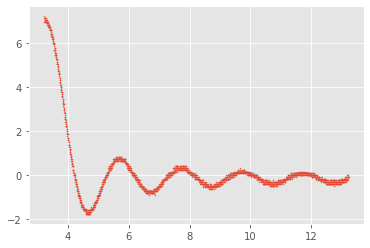

In [8]:
plt.plot(time_array, voltage_array, label='voltage', linestyle='None', marker='.', markersize=1)

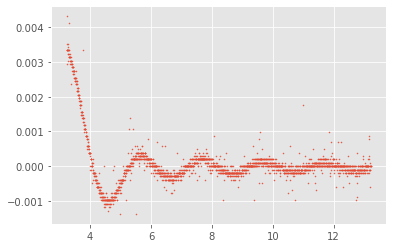

In [9]:
plt.plot(time_array, current_array, label='current', linestyle='None', marker='.', markersize=1)

## Data Treatment

In [10]:
# 'normalising'
t_sf = omega/1.2 # Aim for this to be such that the T of the scaled data is a bit less than 2pi
V_sf = 1/np.max(abs(voltage_array))
I_sf = 1/np.max(abs(current_array))
scaled_time_array = time_array*t_sf
scaled_voltage = voltage_array*V_sf
scaled_current = current_array*I_sf

# structuring
target_array = np.concatenate((scaled_voltage, scaled_current), axis=1)

In [11]:
# random sampling
number_of_samples = scaled_time_array.size

reordered_row_indices = np.random.permutation(scaled_time_array.size)
reduced_time_array = scaled_time_array[reordered_row_indices, :][:number_of_samples]
reduced_target_array = target_array[reordered_row_indices, :][:number_of_samples]

## Predicting coefficients

First of all, we can forget that our problem has scaled data and do two things. First, remember that while capacitance is equivalent to viscosity, reistance is equivalent to the reciprocal of the elastic modulus. Second, we can put these viscosities and resistances into the function for calculating the expected coefficients. Intuitively for once, we interpret the model params as desribing a maxwell model. We do this because it was a Maxwell type model that we constructed on the breadboard, and so the parameters must be combined in a maxwell type fashion to return the equation coefficients.

In [12]:
pre_scaled_coeff_guess = VE_params.coeffs_from_model_params(equiv_E, equiv_eta, mech_model)
pre_scaled_coeff_guess

[0.502512562814070, 2000.00000000000, 1990.00000000000]

Thanks to our scaling, the coefficients we are going to discover here are actually also scaled compared to the coefficients as they would have been if no scaling had taken place. This is because we have two dependant quantities that have been scaled differently. If it had been just one scale factor, the coefficients would have been the same.

The LHS of the equation, the first time derivative of voltage, has been scaled the same way as any other voltage term. As a result, the coefficient(s) for voltage term(s) will already be scaled correctly.  This is because, although the voltage seen by DeepMoD is 10x lower than in reality, this would only need to be balanced by a coeffient 10x higher if the total of the RHS (the LHS) hadn't also been made 10x lower. As the coeffient of the LHS is always one, and the time derivative is now 10x smaller, all terms on the RHS should also be 10x smaller than before. A coefficient on the voltage term remaining that is also 10x smaller is unnecessary, as the voltage is already 10x smaller.

However, for the current terms, they will all be 100x bigger, due to scaling, so the coeffients must be 1000x smaller than an unscaled set of coeffs to preserve each coeff\*term product as being 10x smaller than before scaling, to match the LHS.

In summary, we need to take the current coeffients and divide them by 1000 to predict the coeffients as they will be for the normalised data.

The formula for scaling each cofficient is thus:

$$
c_n = C_n\frac{\alpha_{LHS}}{\alpha_n}
$$

where $C_n$ is the true coeffient for the nth term, $c_n$ is the scaled version that DeepMoD will find, $\alpha_n$ is the scale factor that was applied to the dependant quantity in term n, and $\alpha_{LHS}$ is the scale factor that was applied to the dependant quantity put on the LHS. 

From this we see that the voltage terms on the RHS have no scaling as $\alpha_n = \alpha_{LHS}$

In [13]:
scaled_coeff_guess = VE_params.scaled_coeffs_from_true(pre_scaled_coeff_guess, t_sf, V_sf, I_sf)
scaled_coeff_guess

[0.191945660010326, 0.457700489937477, 1.19226579520697]

## Defining Library

In [14]:
import torch.autograd as auto

def mech_library_real(inputs, **library_config):    
    
    prediction, data = inputs
    
    # The first column of prediction is always strain
    strain_derivs = auto_deriv(data, prediction[:, :1], library_config['diff_order'])
    strain_theta = torch.cat((prediction[:, :1], strain_derivs), dim=1)
    
    # The second column is always stress
    stress_derivs = auto_deriv(data, prediction[:, 1:], library_config['diff_order'])
    stress_theta = torch.cat((prediction[:, 1:], stress_derivs), dim=1)
    
    strain_t = strain_theta[:, 1:2] # Extract the first time derivative of strain
    strain_theta = torch.cat((strain_theta[:, 0:1], strain_theta[:, 2:]), dim=1) # remove this before it gets put into theta
    strain_theta *= -1 # The coefficient of all strain terms will always be negative. rather than hoping deepmod will find these negative terms, we assume the negative factor here and later on DeepMoD will just find positive coefficients
    theta = torch.cat((strain_theta, stress_theta), dim=1) # I have arbitrarily set the convention of making Strain the first columns of data
    
    return [strain_t], theta


def auto_deriv(data, prediction, max_order):
    '''
    data and prediction must be single columned tensors.
    If it is desired to calculate the derivatives of different predictions wrt different data, this function must be called multiple times.
    This function does not return a column with the zeroth derivative (the prediction).
    '''
    
    # First derivative builds off prediction.
    derivs = auto.grad(prediction, data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]
    for _ in range(max_order-1):
        # Higher derivatives chain derivatives from first derivative.
        derivs = torch.cat((derivs, auto.grad(derivs[:, -1:], data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]), dim=1)
            
    return derivs

## DeepMod prep

Transform into tensors for use by pytorch

In [15]:
time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
target_tensor = torch.tensor(reduced_target_array, dtype=torch.float32)

### Configuration

#### Threshold definition

In [16]:
percent = 0.05
def thresh_pc(*args): # Keep as full function so that it can be pickled
    return percent

#### Dictionaries

new library function, simpler even than for synthetic data as no analytical differentiation occurs and voltage (or strain) is always assumed to be the first column of prediction and target. No need for input type or torch lambda entry in dictionary.

In [17]:
library_config = {'library_func': mech_library_real,
                  'diff_order': 3,
                  'coeff_sign': 'positive'}

output_dim is 2! This is because the NN is goign to learn to predict both V and I from t.

In [18]:
network_config = {'hidden_dim': 30}

Have a small period at start to train MSE only. Rational is to trian the MSE a bit, not so much as to fit the noise, but enough to try and guide the first several epochs of the main optimisation process in the right direction. The main optimisaton procedure will seemingly ruin most of the MSE only fit as it warps the data to fit, at this point, nonsense equation, but the hope is that it will briefly nudge the equation in the right direction.

In [19]:
optim_config = {'l1': 10**-5,
                'thresh_func': thresh_pc,
                'lr_coeffs': 0.001}

In [20]:
report_config = {'plot': True}

## Running DeepMoD

In [21]:
scaled_coeff_guess

[0.191945660010326, 0.457700489937477, 1.19226579520697]

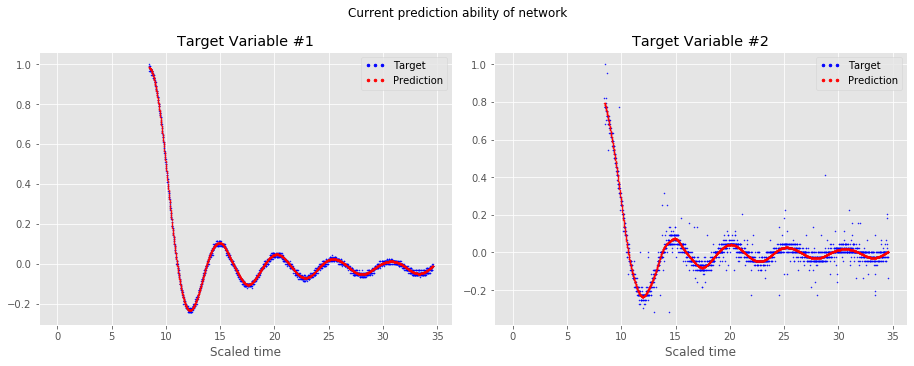

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |     Sign |
      10000     99.99%               0s   1.39e-03   1.39e-03   2.08e-06   0.00e+00   0.00e+00 
[Parameter containing:
tensor([[0.1315],
        [0.4339],
        [1.3487],
        [0.0457]], requires_grad=True)]


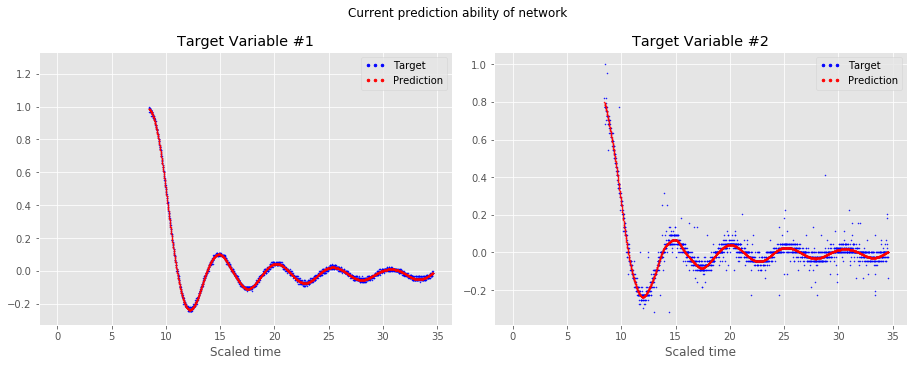

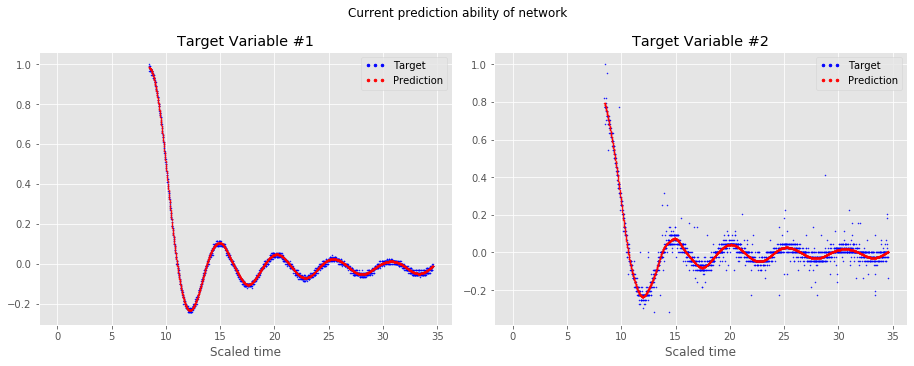

In [22]:
begin_timestamp = datetime.now()
model = run_deepmod(time_tensor, target_tensor, library_config, network_config, optim_config, report_config)

In [23]:
network = model.network
lstsq_guess_list = model.fit.initial_guess
sparse_coeff_vector_list_list = model.fit.coeff_vector_history
scaled_coeff_vector_list_list = [] # NOT IMPLEMENTED
sparsity_mask_list_list = model.fit.sparsity_mask_history

### Results

In [24]:
lstsq_guess_list

In [25]:
[list(plist) for plist in sparse_coeff_vector_list_list]

[[Parameter containing:
  tensor([[ 9.4877e-02],
          [-5.6396e-05],
          [-4.1496e-05],
          [ 4.2082e-01],
          [ 1.3907e+00],
          [ 3.3899e-02],
          [ 5.0497e-02]], requires_grad=True)], [Parameter containing:
  tensor([[0.1315],
          [0.4339],
          [1.3487],
          [0.0457]], requires_grad=True)]]

In [26]:
scaled_coeff_vector_list_list

[]

In [27]:
sparsity_mask_list_list

[[tensor([0, 1, 2, 3, 4, 5, 6])], [tensor([0, 3, 4, 6])]]

### Magnitude of expected coeffs scaled by normalisation from process within deepmod

In [28]:
from deepymod_torch.sparsity import scaling_single_vec

In [29]:
library_diff_order = library_config['diff_order']

# Get time_deriv and theta
# prediction_sc = model.network(time_tensor)
# time_deriv_sc, theta_sc = model.library((prediction_sc, time_tensor))
time_deriv_sc, theta_sc = model.library.time_deriv_list, model.library.theta

# Get sparse theta
exp_diff_order_sc = len(equiv_eta)
strain_mask_sc = list(range(exp_diff_order_sc))
stress_mask_sc = list(range(library_diff_order, exp_diff_order_sc+library_diff_order+1))
sparsity_mask_sc = strain_mask_sc + stress_mask_sc
sparse_theta_sc = theta_sc[:, sparsity_mask_sc]

# Get exp coeffs
expected_coeffs_sc = torch.tensor(scaled_coeff_guess, dtype=torch.float32).reshape(-1, 1)

In [30]:
scaling_single_vec(expected_coeffs_sc, sparse_theta_sc, time_deriv_sc[0])

tensor([[0.2791],
        [0.4788],
        [1.0055]], grad_fn=<MulBackward0>)

## Result Model Validation

In [31]:
time_tensor_post = torch.tensor(scaled_time_array, dtype=torch.float32, requires_grad=True)
prediction_tensor = network(time_tensor_post)
full_prediction_array = np.array(prediction_tensor.detach())
predict_voltage_array, predict_current_array = full_prediction_array[:, 0], full_prediction_array[:, 1]
library_diff_order = library_config['diff_order']
final_coeff_vector = sparse_coeff_vector_list_list[-1][0].clone().detach()
final_sparsity_mask = sparsity_mask_list_list[-1][0].clone()

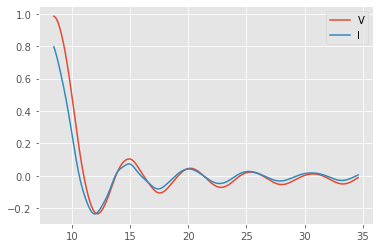

In [32]:
plt.plot(scaled_time_array, predict_voltage_array, label='V')
plt.plot(scaled_time_array, predict_current_array, label='I')
plt.legend()

### Expected coeffs match with prediction?

In [33]:
errors = VE_datagen.equation_residuals(scaled_time_array, predict_voltage_array, predict_current_array, scaled_coeff_guess)

0.008308882239659868


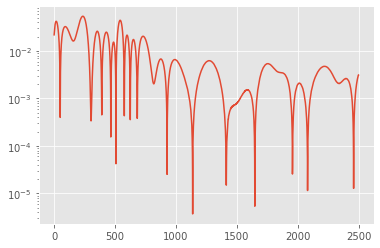

In [34]:
print(np.mean(abs(errors[library_diff_order:-library_diff_order])))
plt.semilogy(abs(errors.flatten()))

### DeepMoD coeffs match with prediction?

In [35]:
errors = VE_datagen.equation_residuals(scaled_time_array, predict_voltage_array, predict_current_array, final_coeff_vector, sparsity_mask=final_sparsity_mask, diff_order=library_diff_order)

0.0017270766816792713


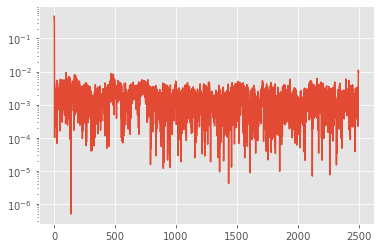

In [36]:
print(np.mean(abs(errors[library_diff_order:-library_diff_order])))
plt.semilogy(abs(errors.flatten()))

Cannot check against target because highly noisy, num derivs not possible.

### Model before thresholding

#### Plotting data from coeffs

In [37]:
bt_coeff_vector = sparse_coeff_vector_list_list[0][0].clone()
bt_sparsity_mask = sparsity_mask_list_list[0][0].clone()

In [38]:
response_recalc_bt = VE_datagen.calculate_int_diff_equation(time_tensor_post, prediction_tensor[:, 1], network, bt_coeff_vector, bt_sparsity_mask, library_diff_order, input_type)

In [39]:
# Alt finite difference method
bt_coeff_vector_array = np.array(bt_coeff_vector.detach())
response_recalc_bt_fd = VE_datagen.calculate_finite_difference_diff_equation(scaled_time_array, predict_voltage_array, predict_current_array, bt_coeff_vector_array, bt_sparsity_mask, library_diff_order, input_type)

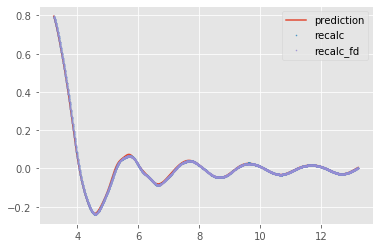

In [40]:
plt.plot(time_array.flatten(), predict_current_array.flatten(), label='prediction')
plt.plot(time_array.flatten(), response_recalc_bt.flatten(), label='recalc', marker='.', markersize=1, linestyle='None')
plt.plot(time_array.flatten(), response_recalc_bt_fd.flatten(), label='recalc_fd', marker='.', markersize=1, linestyle='None')
plt.legend()

### Model after thresholding

#### Plotting data from coeffs

In [41]:
response_recalc_at = VE_datagen.calculate_int_diff_equation(time_tensor_post, prediction_tensor[:, 1], network, final_coeff_vector, final_sparsity_mask, library_diff_order, input_type)

In [42]:
# Alt finite difference method
final_coeff_vector_array = np.array(final_coeff_vector.detach())
response_recalc_at_fd = VE_datagen.calculate_finite_difference_diff_equation(scaled_time_array, predict_voltage_array, predict_current_array, final_coeff_vector_array, final_sparsity_mask, library_diff_order, input_type)

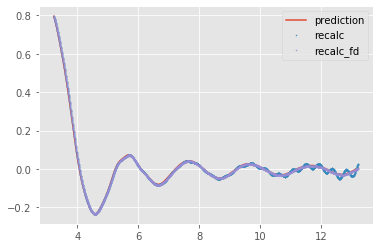

In [43]:
plt.plot(time_array.flatten(), predict_current_array.flatten(), label='prediction')
plt.plot(time_array.flatten(), response_recalc_at.flatten(), label='recalc', marker='.', markersize=1, linestyle='None')
plt.plot(time_array.flatten(), response_recalc_at_fd.flatten(), label='recalc_fd', marker='.', markersize=1, linestyle='None')
plt.legend()

## Results Processing

In [44]:
prediction_array = np.array(network(time_tensor).detach())

In [45]:
target_coeffs_array = np.array(scaled_coeff_guess).reshape(-1,1)

pre_thresh_coeffs_array = np.array(sparse_coeff_vector_list_list[0][0].detach())
# pre_thresh_scaled_coeffs_array = np.array(scaled_coeff_vector_list_list[0][0].detach())

final_coeffs_array = np.array(sparse_coeff_vector_list_list[-1][0].detach())
sparsity_mask_array = np.array(sparsity_mask_list_list[-1][0]).reshape(-1,1)
unscaled_final_coeffs = VE_params.true_coeffs_from_scaled(final_coeffs_array, t_sf, V_sf, I_sf, mask=sparsity_mask_array, library_diff_order=library_diff_order)
true_coeffs_array = np.array(unscaled_final_coeffs).reshape(-1, 1)
# final_scaled_coeffs_array = np.array(scaled_coeff_vector_list_list[-1][0].detach())

In [46]:
raw_series_data = np.concatenate((time_array, voltage_array, current_array), axis=1)
NN_series_data = np.concatenate((reduced_time_array, reduced_target_array, prediction_array), axis=1)
# pre_thresh_coeffs_data = np.concatenate((pre_thresh_coeffs_array, pre_thresh_scaled_coeffs_array), axis=1)
# final_coeffs_data = np.concatenate((final_coeffs_array, final_scaled_coeffs_array, sparsity_mask_array), axis=1)

pre_thresh_coeffs_data = pre_thresh_coeffs_array
final_coeffs_data = np.concatenate((final_coeffs_array, true_coeffs_array, sparsity_mask_array), axis=1)

In [47]:
dt_string = begin_timestamp.strftime('%d/%m/%Y %H:%M:%S')

In [48]:
raw_data_info_list = ['Model: '+mech_model, f'E: {equiv_E}', f'eta: {equiv_eta}', 'Input: '+input_type, 'Desc: '+func_desc, f'omega: {omega}', f'Amp: {Amp}', f'R_shunt: {r_shunt}']
raw_data_info_list

['Model: GKM',
 'E: [0.0005025125628140704, 0.0005025125628140704]',
 'eta: [0.001]',
 'Input: Strain',
 'Desc: Half Sinc',
 'omega: 3.141592653589793',
 'Amp: 7',
 'R_shunt: 10.2']

In [49]:
treatment_info_list = [f'time_sf: {t_sf}', f'voltage_sf: {V_sf}', f'current_sf: {I_sf}']
treatment_info_list

['time_sf: 2.6179938779914944',
 'voltage_sf: 0.1388888888888889',
 'current_sf: 231.81818181818184']

In [50]:
config_dict_list = [f'library: {library_config}', f'network: {network_config}', f'optim: {optim_config}', f'report: {report_config}']
config_dict_list

["library: {'library_func': <function mech_library_real at 0x7ff0ed12b378>, 'diff_order': 3, 'coeff_sign': 1}",
 "network: {'hidden_dim': 30, 'pre_trained_network': None, 'layers': 4}",
 "optim: {'l1': 1e-05, 'thresh_func': <function thresh_pc at 0x7ff0ed12bbf8>, 'lr_coeffs': 0.001, 'PINN': False, 'kappa': 1, 'lr_nn': 0.001, 'betas': (0.9, 0.999), 'amsgrad': False, 'mse_only_iterations': None, 'max_iterations': 100001, 'final_run_iterations': 10001, 'use_lstsq_approx': False}",
 "report: {'plot': True, 'print_interval': 1000}"]

In [51]:
misc_list = ['date_stamp: '+dt_string, f'NumPy_seed: {np_seed}', f'Torch_seed: {torch_seed}']
misc_list

['date_stamp: 18/06/2020 13:44:54', 'NumPy_seed: 2', 'Torch_seed: 0']

## Saving

In [52]:
parent_folder = '../data/Results/Real/'
first_subfolder = f'{mech_model} {equiv_E} {equiv_eta} {input_type} {func_desc} omega {omega} order {library_diff_order} lambda {optim_config["l1"]} all points'.replace('.', '-')

foldername = parent_folder + first_subfolder

In [53]:
if not os.path.isdir(foldername):
    os.makedirs(foldername)

In [54]:
np.savetxt(foldername+'/raw_series_data.csv', raw_series_data, delimiter=',', header='Time, Voltage, Current')
np.savetxt(foldername+'/NN_series_data.csv', NN_series_data, delimiter=',', header='Time, Target (V), Target (I), Prediction (V), Prediction (I)')
np.savetxt(foldername+'/expected_coeffs.csv', target_coeffs_array, delimiter=',', header='Expected_coeffs')
# np.savetxt(foldername+'/pre_thresh_coeffs_data.csv', pre_thresh_coeffs_data, delimiter=',', header='Trained_Coeffs, Scaled_Trained_Coeffs')
# np.savetxt(foldername+'/final_coeffs_data.csv', final_coeffs_data, delimiter=',', header='Trained_Coeffs, Scaled_Trained_Coeffs, Sparsity_Mask')

np.savetxt(foldername+'/pre_thresh_coeffs_data.csv', pre_thresh_coeffs_data, delimiter=',', header='Trained_Coeffs')
np.savetxt(foldername+'/final_coeffs_data.csv', final_coeffs_data, delimiter=',', header='Trained_Coeffs, Unscaled, Sparsity_Mask')
np.savetxt(foldername+'/full_prediction.csv', full_prediction_array, delimiter=',', header='Full Prediction Voltage, Full Prediction Current')

In [55]:
with open(foldername+'/raw_data_info_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in raw_data_info_list)

In [56]:
with open(foldername+'/treatment_info_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in treatment_info_list)

In [57]:
with open(foldername+'/config_dict_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in config_dict_list)

In [58]:
with open(foldername+'/misc_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in misc_list)

In [59]:
with open(foldername+'/model.pickle', 'wb') as file:
    pickle.dump(model, file) # Will fail on dump if using lambda funcs, will fail on load if normal funcs that are not redefined.

## Rediscovering model parameters

We need to take the coefficients that DeepMoD has found and reverse the process in predicting coeffients.

First we do the reverse scaling of the coeffs, this time dividing by the multiplication factor previously found, to scale the scaled coefficients to the true ones. (DONE ABOVE NOW)

In [60]:
true_coeffs = list(true_coeffs_array.flatten())

We next use these coefficients to recover our model parameters.

In [61]:
recovered_mech_params = VE_params.model_params_from_coeffs(true_coeffs, mech_model, True)[0][0]
recovered_mech_params

ValueError: No viable mech model discoverable from an even number of coefficients.

Lastly, these parameters correspond to viscosities and elastic moduli, not capacitances and resistances. They actually do correspond to the capacitance and conductivity, but if we want resistance, we must take the reciprocal of all the 'elastic moduli' terms.

In [ ]:
terms = len(true_coeffs)

recovered_elec_params = list(recovered_mech_params)
for idx in range(terms//2 + 1):
    recovered_elec_params[idx] = 1/recovered_elec_params[idx]

recovered_elec_params

#### Save results if poss

In [ ]:
recovered_elec_params_array = np.array(recovered_elec_params).reshape(-1,1)
np.savetxt(foldername+'/recovered_elec_params.csv', recovered_elec_params, delimiter=',', header='Recovered')